# 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터 파일 읽어오기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print("train data 개수: {}, test data 개수: {}".format(len(train_data), len(test_data)))  # 데이터 개수 확인
train_data.head()  # 데이터 출력

train data 개수: 150000, test data 개수: 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어

# 데이터 로더 함수 정의
def load_data(train_data, test_data, num_words=10000):
    # train data 전처리
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 특수문자 제거
    train_data['document'].replace('', np.nan, inplace=True)  # 공백은 Null로 변경
    train_data = train_data.dropna(how = 'any')  # 결측치 제거
    # test data 전처리
    test_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 특수문자 제거
    test_data['document'].replace('', np.nan, inplace=True)  # 공백은 Null로 변경
    test_data = test_data.dropna(how = 'any')  # 결측치 제거

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 단어사전 만들기
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)  # 단어 빈도순으로 (10000-4)개 가져오기
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  # 앞부분 4개 추가
    word_to_index = {word:index for index, word in enumerate(vocab)}  # {단어:인덱스} 단어사전 생성
    
    # 리뷰 텍스트를 단어사전 인덱스로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

# 데이터 로더 실행하여 데이터셋 생성
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("train data 개수: {}, test data 개수: {}".format(len(X_train), len(X_test)))

index_to_word = {index:word for word, index in word_to_index.items()}  # {인덱스:단어} 딕셔너리 생성

/tmp/ipykernel_662/3300053641.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 특수문자 제거
/tmp/ipykernel_662/3300053641.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 특수문자 제거


train data 개수: 145791, test data 개수: 48995


In [3]:
# 인코딩 & 디코딩 함수 정의
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# decode된 문장과 라벨을 비교하여 일치하는지 확인
for i in range(10):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('라벨: ', y_train[i])

[27, 67, 895, 33, 214, 15, 28, 699]
더 빙 진짜 짜증 나 네요 목소리
라벨:  0
[977, 481, 491, 636, 4, 110, 1554, 48, 866, 949, 11, 38, 364]
포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
라벨:  1
[19, 192, 2]
재 <UNK>
라벨:  0
[8035, 143, 4134, 277, 85, 13, 5, 52, 3326]
이야기 구먼 솔직히 재미 없 다 평점 조정
라벨:  0
[2, 8488, 1051, 48, 2702, 54, 4, 2625, 34, 1118, 29, 326, 36, 17, 35, 54, 2, 2, 393, 2850, 1677, 5]
익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
라벨:  1
[627, 2, 2, 425, 171, 1464, 661, 1592, 665, 46, 2, 4, 61, 2167, 118, 718]
<UNK> <UNK> 세 부터 초등 학교 학년 생 인 <UNK> 영화 ㅋㅋㅋ 별반 개 아까움
라벨:  0
[237, 351, 8, 354, 1909, 51, 11, 780, 5]
긴장감 을 제대로 살려 내 지 못했 다
라벨:  0
[232, 1344, 132, 5, 392, 705, 2, 2, 48, 1434, 269, 93, 233, 23, 882, 24, 321, 608, 501, 475, 546, 5, 3165, 8489, 17, 1386, 1386, 65, 282, 13, 5, 48, 95, 7, 70, 17, 2, 37]
반개 아깝 다 욕 나온다 <UNK> <UNK> 연기 생활 몇 년 인지 정말 발 로 해도 그것 보단 낫 겟 다 납치 감금 만 반복 반복 드라마 가족 없 다 연기 못 하 사람 만 <UNK> 네
라벨:  0
[117, 13, 18, 85, 12, 269, 22, 43, 4]
없 는데 재미 있 몇 안 되 영화
라벨:  1
[57, 612

# 3.  모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [4]:
# 텍스트 데이터 문장 길이의 리스트 생성
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장 길이의 평균, 최대값, 표준편차 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 계산
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) *100))

문장길이 평균 :  13.757179674103888
문장길이 최대 :  83
문장길이 표준편차 :  11.462771769216866
pad_sequences maxlen :  36
전체 문장의 93.38145451931864%가 maxlen 설정값 이내에 포함됩니다. 


In [5]:
# padding으로 문장 길이 맞추기
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

print(X_train.shape)

(145791, 36)


# 4. 모델 구성 및 validation set 구성

In [6]:
# 훈련용 데이터셋 145791건 중 40000건을 분리하여 validation set으로 사용
x_val = X_train[:40000]
y_val = y_train[:40000]

# validation set을 제외한 나머지는 train set으로 사용
partial_x_train = X_train[40000:]
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(105791, 36)
(105791,)


# 5. 모델 훈련, 평가

# 5-1. LSTM

In [7]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# LSTM 레이어로 모델 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [8]:
# model 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
207/207 [==============================] - 5s 8ms/step - loss: 0.5889 - accuracy: 0.6725 - val_loss: 0.4194 - val_accuracy: 0.8278
Epoch 2/5
207/207 [==============================] - 1s 6ms/step - loss: 0.3683 - accuracy: 0.8438 - val_loss: 0.3607 - val_accuracy: 0.8421
Epoch 3/5
207/207 [==============================] - 1s 6ms/step - loss: 0.3310 - accuracy: 0.8595 - val_loss: 0.3642 - val_accuracy: 0.8399
Epoch 4/5
207/207 [==============================] - 1s 6ms/step - loss: 0.3156 - accuracy: 0.8656 - val_loss: 0.3612 - val_accuracy: 0.8398
Epoch 5/5
207/207 [==============================] - 1s 6ms/step - loss: 0.3038 - accuracy: 0.8715 - val_loss: 0.3661 - val_accuracy: 0.8394


In [9]:
# test set으로 model 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 3s - loss: 0.3742 - accuracy: 0.8362
[0.37416622042655945, 0.8362077474594116]


# 5-2. 1-D CNN

In [10]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [11]:
# model 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
207/207 [==============================] - 3s 6ms/step - loss: 0.5217 - accuracy: 0.7477 - val_loss: 0.3777 - val_accuracy: 0.8328
Epoch 2/5
207/207 [==============================] - 1s 5ms/step - loss: 0.3414 - accuracy: 0.8525 - val_loss: 0.3565 - val_accuracy: 0.8421
Epoch 3/5
207/207 [==============================] - 1s 5ms/step - loss: 0.3044 - accuracy: 0.8719 - val_loss: 0.3593 - val_accuracy: 0.8425
Epoch 4/5
207/207 [==============================] - 1s 5ms/step - loss: 0.2760 - accuracy: 0.8869 - val_loss: 0.3672 - val_accuracy: 0.8402
Epoch 5/5
207/207 [==============================] - 1s 5ms/step - loss: 0.2509 - accuracy: 0.9008 - val_loss: 0.3783 - val_accuracy: 0.8386


In [12]:
# test set으로 model 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 2s - loss: 0.3861 - accuracy: 0.8373
[0.38614100217819214, 0.8372895121574402]


# 5-3. GlobalMaxPooling1D

In [13]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [14]:
# model 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
207/207 [==============================] - 1s 4ms/step - loss: 0.6282 - accuracy: 0.6636 - val_loss: 0.5066 - val_accuracy: 0.8043
Epoch 2/5
207/207 [==============================] - 1s 4ms/step - loss: 0.4287 - accuracy: 0.8285 - val_loss: 0.3908 - val_accuracy: 0.8306
Epoch 3/5
207/207 [==============================] - 1s 4ms/step - loss: 0.3510 - accuracy: 0.8551 - val_loss: 0.3673 - val_accuracy: 0.8378
Epoch 4/5
207/207 [==============================] - 1s 4ms/step - loss: 0.3141 - accuracy: 0.8714 - val_loss: 0.3630 - val_accuracy: 0.8409
Epoch 5/5
207/207 [==============================] - 1s 4ms/step - loss: 0.2886 - accuracy: 0.8827 - val_loss: 0.3658 - val_accuracy: 0.8398


In [15]:
# test set으로 model 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 2s - loss: 0.3742 - accuracy: 0.8375
[0.37421712279319763, 0.8375344276428223]


# 6. Loss, Accuracy 그래프 시각화

# 6-1. LSTM

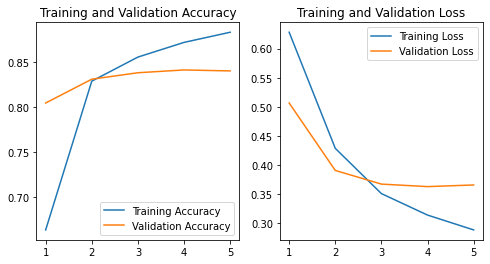

In [16]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 6-2. 1-D CNN

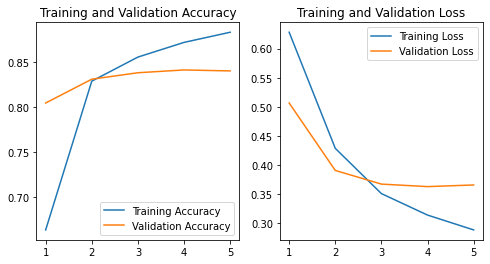

In [17]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 6-3. GlobalMaxPooling1D

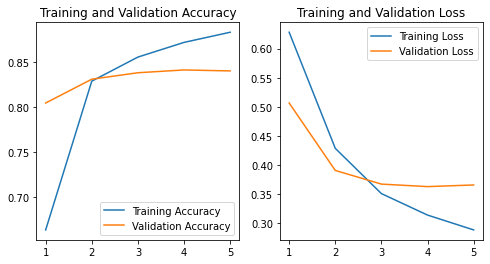

In [18]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 7. 학습된 Embedding 레이어 분석

In [19]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

# 임베딩 레이어 차원 확인
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [20]:
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [21]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("재미")  # 학습이 잘 되지 않아 별로 유사하지 않음

[('엔', 0.930435836315155),
 ('시점', 0.9229069948196411),
 ('완전', 0.9191941022872925),
 ('했으며', 0.91810142993927),
 ('때', 0.9161176681518555),
 ('그만큼', 0.9153724908828735),
 ('진짜', 0.9101454019546509),
 ('러브', 0.891006350517273),
 ('진심', 0.8714962005615234),
 ('내용', 0.869359016418457)]

# 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [22]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec_path

'/aiffel/aiffel/sentiment_classification/ko.bin'

In [23]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector.shape     # 200dim의 워드 벡터

/tmp/ipykernel_662/2695734089.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['영화']


(200,)

In [24]:
# 유사한 단어와 그 유사도 확인
word2vec.wv.most_similar("재미")  # 학습이 잘 되어 유사함

[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [25]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000     # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 차례대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_662/1410859879.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_662/1410859879.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [26]:
# 모델 구성
# LSTM 레이어를 이용한 model을 설계

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [27]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1653/1653 [==============================] - 12s 6ms/step - loss: 0.4411 - accuracy: 0.7774 - val_loss: 0.3535 - val_accuracy: 0.8447
Epoch 2/5
1653/1653 [==============================] - 10s 6ms/step - loss: 0.3075 - accuracy: 0.8670 - val_loss: 0.3304 - val_accuracy: 0.8555
Epoch 3/5
1653/1653 [==============================] - 10s 6ms/step - loss: 0.2620 - accuracy: 0.8895 - val_loss: 0.3310 - val_accuracy: 0.8555
Epoch 4/5
1653/1653 [==============================] - 10s 6ms/step - loss: 0.2222 - accuracy: 0.9092 - val_loss: 0.3551 - val_accuracy: 0.8557
Epoch 5/5
1653/1653 [==============================] - 10s 6ms/step - loss: 0.1847 - accuracy: 0.9257 - val_loss: 0.3740 - val_accuracy: 0.8532


In [28]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)   # 정확도가 0.85으로 개선됨

1532/1532 - 4s - loss: 0.3792 - accuracy: 0.8514
[0.37918955087661743, 0.8514134287834167]


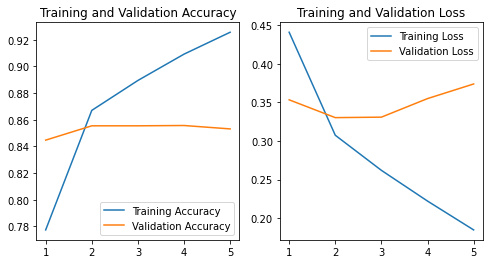

In [29]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 회고

- 이번 프로젝트에서는 LSTM, 1-D CNN, GlobalMaxPooling1D으로 모델을 학습시켰다. 정확도는 모두 83%대로 큰 차이는 없었다. epoch을 10으로 했을 때 training loss는 감소하고  validation loss는 증가하는 것을 확인할 수 있었다. 그래서 epoch을 5로 줄여 그 격차를 줄였다.
- gensim의 유사단어 찾기를 통해 자체학습한 임베딩과 사전학습된 임베딩을 비교해보면 '재미'라는 단어로 유사단어에서 차이점이 있었다. 자체학습한 임베딩은 '재미'와 관련없는 단어들이 word2vec으로 사전학습된 임베딩보다 더 많았다. 이로써 한국어 Word2Vec 임베딩에서 유사도가 높은 단어가 꽤 나와 사전학습이 잘 이루어졌음을 알 수 있었다.
- word2vec을 사용하여 정확도를 85%로 향상시킬 수 있었다. 하지만 하이퍼파라미터를 조정해도 그 이상으로 올리기는 어려웠다. 아무래도 한국어다 보니까 영어 텍스트에 비해서 큰 효과가 안나타는 것 같고 네이버 영화리뷰 데이터내에서 노이즈가 포함되어 있을 것 같다.